# Measuring Cosmological Distances to Fast Radio Bursts with Arrival Time Differences

This notebook contains a series of calculations related to measuring cosmological distances to fast radio bursts with arrival time differences. These calculations are described in detail in Boone et al. 2022 (in prep.)

In [1]:
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import astropy.constants as const
import astropy
import numpy as np
from matplotlib import pyplot as plt

# Plot the time delay vs distance

In [2]:
dist = np.logspace(0, 5)
def plot_accuracy(separation, color, label=None):
    dt = (separation * u.AU)**2 / (astropy.constants.c) / (dist * u.Mpc) / 2
    dt = dt.to(u.ns)
    
    plt.plot(dist, dt, c=color, label=label)
    # plt.text(dist[-1] * 1.1, dt[-1].value / 1.3, f'{separation} AU')
    plt.text(dist[0] / 1.1, dt[0].value / 1.3, f'{separation} AU', ha='right', c=color)

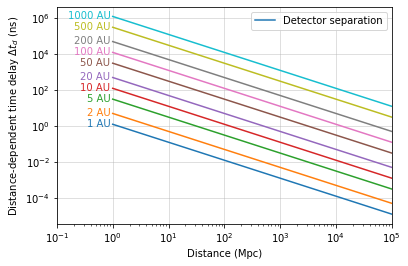

In [3]:
plt.figure()
plot_accuracy(1, 'C0', label='Detector separation')
plot_accuracy(2, 'C1')
plot_accuracy(5, 'C2')
plot_accuracy(10, 'C3')
plot_accuracy(20, 'C4')
plot_accuracy(50, 'C5')
plot_accuracy(100, 'C6')
plot_accuracy(200, 'C7')
plot_accuracy(500, 'C8')
plot_accuracy(1000, 'C9')
plt.xlabel('Distance (Mpc)')
plt.ylabel('Distance-dependent time delay $\Delta t_d$ (ns)')
plt.xscale('log')
plt.yscale('log')
# plt.axhline(0.01, label='Estimated measurement accuracy', c='k', lw=2, ls='--')
plt.legend()
plt.grid(alpha=0.5)
plt.xlim(0.1, 1e5)
plt.savefig('./time_delay_vs_dist.pdf')

In [4]:
from astropy.cosmology import Planck18_arXiv_v2 as cosmo

dist = np.logspace(0, 5)
def plot_uncertainty(separation, color):
    dt = (separation * u.AU)**2 / (astropy.constants.c) / (dist * u.Mpc) / 2.
    dt = dt.to(u.ns)
    uncertainty = 0.1 / dt

    plt.plot(dist, uncertainty, c=color)
    # plt.text(dist[-1] * 1.1, dt[-1].value / 1.3, f'{separation} AU')
    plt.text(dist[0] / 1.1, uncertainty[0].value / 1.3, f'{separation} AU', ha='right', c=color)

def plot_uncertainty_redshift(separation, color):
    redshift = np.logspace(-2, 5)
    dist = cosmo.lookback_time(redshift) * const.c
    dt = (separation * u.AU)**2 / (astropy.constants.c) / dist / 2.
    dt = dt.to(u.ns)
    uncertainty = 0.1 / dt

    plt.plot(redshift, uncertainty, c=color)
    # plt.text(dist[-1] * 1.1, dt[-1].value / 1.3, f'{separation} AU')
    plt.text(redshift[0] / 1.1, uncertainty[0].value / 1.3, f'{separation} AU', ha='right', c=color)

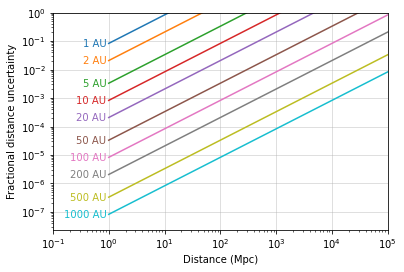

In [5]:
# Plot the uncertainty vs distance for different detector separations
plt.figure()
plot_uncertainty(1, 'C0')
plot_uncertainty(2, 'C1')
plot_uncertainty(5, 'C2')
plot_uncertainty(10, 'C3')
plot_uncertainty(20, 'C4')
plot_uncertainty(50, 'C5')
plot_uncertainty(100, 'C6')
plot_uncertainty(200, 'C7')
plot_uncertainty(500, 'C8')
plot_uncertainty(1000, 'C9')
plt.xlabel('Distance (Mpc)')
plt.ylabel('Fractional distance uncertainty')
plt.xscale('log')
plt.yscale('log')
# plt.axhline(1, label='Estimated detector uncertainty', c='k', lw=2, ls='--')
# plt.legend()
plt.grid(alpha=0.5)
plt.xlim(0.1, 1e5)
plt.ylim(None, 1)
plt.savefig('./dist_precision.pdf')

# MCMC tests of 3d detector configurations

In [6]:
from astropy import units as u
from astropy import constants as const
import emcee
import corner

# Define measurement accuracy
dt_accuracy = 0.1 * u.ns

# Define the detector geometry
# We always assume that there is a detector at [0, 0, 0]

# tetrahedron = np.array([
    # [1., 1., 0.],
    # [1., 0., 1.],
    # [0., 1., 1.],
# ]) / np.sqrt(2)
# detectors = 100. * tetrahedron * u.AU

detectors = np.array([
    [10., 0., 0],
    [-10., 0., 0.],
    [0., 10., 0.],
], dtype=np.longdouble) * u.AU


# Define the location of the source

dist = 100. * u.Mpc
theta = np.pi / 2.
phi = np.pi / 3.

def to_xyz(dist, theta, phi):
    x = dist * np.sin(theta) * np.cos(phi)
    y = dist * np.sin(theta) * np.sin(phi)
    z = dist * np.cos(theta)
    
    return x, y, z

print(to_xyz(dist, theta, phi))

def calc_dt(detector, dist, theta, phi):
    x = np.linalg.norm(detector)
    target_coord = to_xyz(dist, theta, phi)
    cos_theta = np.dot(detector, target_coord) / x / dist
    dt = (x * cos_theta / const.c - x**2 * (1 - cos_theta**2) / 2 / dist / const.c)

    return dt

obs_dts = u.Quantity([calc_dt(i, dist, theta, phi) for i in detectors])

def chisq(x):
    raw_dist, theta, phi = x
    dist = raw_dist * u.Mpc

    dts = u.Quantity([calc_dt(i, dist, theta, phi) for i in detectors])

    chisq = np.sum(((dts - obs_dts) / dt_accuracy).to(u.dimensionless_unscaled).value**2)
    return chisq

(<Quantity 50. Mpc>, <Quantity 86.60254038 Mpc>, <Quantity 6.123234e-15 Mpc>)


In [7]:
# Run emcee
def log_prob(x):
    return -0.5 * chisq(x)

ndim, nwalkers = 3, 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)

start_dist = np.random.normal(dist.value, 0.02 * dist.value, nwalkers)
start_theta = np.random.normal(theta, 1e-13, nwalkers)
start_phi = np.random.normal(phi, 1e-13, nwalkers)
start = np.array([start_dist, start_theta, start_phi]).T

sampler.run_mcmc(start, 1000);

distance 8.323309335676484
theta 1.3399148978681134e-07
phi 1.5680426524107256e-14


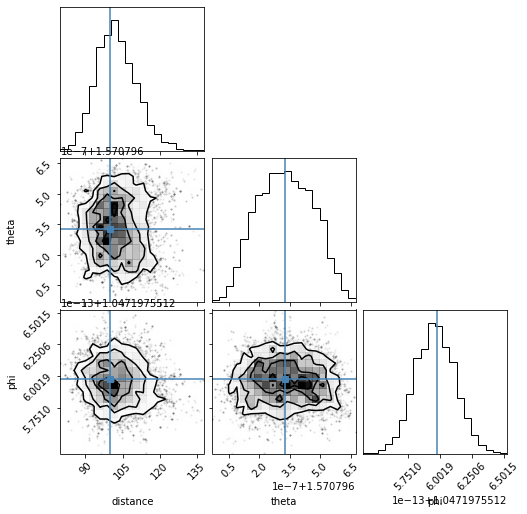

In [8]:
# Show the results
flat_samples = sampler.get_chain(discard=500, flat=True)
labels = ['distance', 'theta', 'phi']

fig = corner.corner(flat_samples, labels=labels, truths=[dist.value, theta, phi])

for i in range(3):
    print(labels[i], np.std(flat_samples[:, i]))

# Gravitational time delay tests

In [9]:
import astropy.units as u
import astropy.constants as const

In [10]:
# C
# The first order linear term

def time_delay(dist, mass, angle, sep):
    """Calculate the gravitational time delay from a star

    The first order linear term is degenerate with the positions
    of the stars on the sky. It has no effect on the distance measurement
    since we are measuring the curvature.

    The second order quadratic term does affect distances.
    
    This function returns both the first order and second order terms.

    Parameters
    ----------
    dist : `~astropy.units.Quantity`
        Distance to the source
    mass : `~astropy.units.Quantity`
        Mass of the lensing star
    angle : `~astropy.units.Quantity`
        Angle between the source and the star on the sky.
    sep : `~astropy.units.Quantity`
        Detector separation.
    
    Returns
    -------
    float
        First order time delay
    float
        Second order time delay
    """
    base_sep = (np.sin(angle.to(u.radian).value) * dist).to(u.AU)
    prefactor = 2 * const.G * mass / const.c**3
    dt = prefactor * 2 * sep / base_sep
    dt2 = prefactor * sep**2 / base_sep**2

    return dt.to(u.ns), dt2.to(u.ns)

In [11]:
# Alpha centauri
time_delay(4 * u.lightyear, 2.4e29 * u.kg, 1 * u.degree, 10 * u.AU)

(<Quantity 5.38642082 ns>, <Quantity 0.00610036 ns>)

In [12]:
# Sirius
time_delay(8.6 * u.lightyear, 7 * u.M_sun, 1 * u.degree, 10 * u.AU)

(<Quantity 145.29629127 ns>, <Quantity 0.07653701 ns>)

In [13]:
# Sun
time_delay(100 * u.AU, 1. * u.M_sun, 90 * u.degree, 10 * u.AU)

(<Quantity 1970.19637906 ns>, <Quantity 98.50981895 ns>)

# Maximum allowed scattering time

In [14]:
# Calculate the maximum scattering time that won't be resolved

def max_scattering_time(D, d, x, nu):
    return (D**2 * const.c * nu**2 / 2 / d / x**2 / u.GHz**4).to(u.ms)

print(max_scattering_time(1 * u.Gpc, 10 * u.kpc, 100 * u.AU, 10 * u.GHz))
print(max_scattering_time(100 * u.Mpc, 10 * u.kpc, 10 * u.AU, 10 * u.GHz))
print(max_scattering_time(1000 * u.Mpc, 10 * u.kpc, 100 * u.AU, 50 * u.GHz))

0.20667618119951886 ms
0.20667618119951883 ms
5.166904529987971 ms


# Size of dish required

In [15]:
def flux_limit(D, delta_nu=1*u.GHz, tau=1*u.ms, s2n=5, eta=0.5, tsys=20*u.K):
    return (s2n * 8 * const.k_B * tsys / (eta * np.pi * D**2 * np.sqrt(delta_nu * tau))).to(u.Jy)

In [16]:
flux_limit(10 * u.m)

<Quantity 7.03158762 Jy>

In [17]:
flux_limit(25 * u.m)

<Quantity 1.12505402 Jy>

## Field of view

In [18]:
def field_of_view(D, nu):
    return (4 * const.c**2 / (np.pi * D**2 * nu**2)).to(u.dimensionless_unscaled) * u.sr

In [19]:
field_of_view(10*u.m, 10*u.GHz)

<Quantity 1.14433063e-05 sr>

In [20]:
field_of_view(25*u.m, 10*u.GHz)

<Quantity 1.83092902e-06 sr>

# Difference in DM time delay

In [21]:
def diff_dm_time_delay(s, nu, L=1*u.kpc):
    cn2 = 5e-17 * u.cm**(-20/3)
    var_dm = 1.11833 * const.e.esu**4 * L * cn2 * s**(5/3) / (4 * np.pi**3 * const.m_e**2 * const.c**2 * nu**4)
    return np.sqrt(var_dm).to(u.ns)

In [22]:
diff_dm_time_delay(100 * u.AU, 10 * u.GHz)

<Quantity 13.93843869 ns>

# Refraction time delay

In [23]:
def refraction_time_delay(nu, ls, L=1*u.kpc):
    cn2 = 5e-17 * u.cm**(-20/3)
    
    var_diff = (3 * const.e.esu**4 * L * cn2 / (8 * np.pi**3 * const.m_e**2 * const.c**2 * nu**4)
                * (2 * np.pi / ls)**(1/3))
    
    sigma_t = const.c * L / np.sqrt(2) * var_diff
    
    return sigma_t.to(u.ns)

In [24]:
refraction_time_delay(10*u.GHz, 10**11 * u.cm, u.kpc)

<Quantity 0.0003463 ns>